# Stock Prediction Capstone Project

In this project, you will work on predicting stock prices using Long Short-Term Memory (LSTM) networks implemented in PyTorch. This project will guide you through the steps of preparing the data, building the LSTM model, training the model, and making predictions.

## Note/Disclaimer:
Before starting this project, it is highly recommended to read up on LSTM networks and understand how they work on a high level and how they're generally implemented with PyTorch. This will help you grasp the concepts better as you work through the project. Here are some resources to get you started:
- [Video to Help Understand LSTMs](https://www.youtube.com/watch?v=YCzL96nL7j0)
- [Resource for Implementing LSTMs for Time Series Prediction with PyTorch](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)
- [Resource for Implementing LSTMs with PyTorch](https://wandb.ai/sauravmaheshkar/LSTM-PyTorch/reports/Using-LSTM-in-PyTorch-A-Tutorial-With-Examples--VmlldzoxMDA2NTA5)
- [PyTorch Documentation for Implementing LSTMs](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)


## Project Steps Overview:
1. **Data Preprocessing:** Load and preprocess the stock price data.
2. **Model Building:** Define the LSTM model architecture using PyTorch.
3. **Model Training:** Train the LSTM model with the prepared data.
4. **Prediction:** Use the trained model to make stock price predictions.

Let's get started! Provided below is some starter code to get you set up with the data and packages/imports.



1. **Importing Libraries**: First, we import the necessary libraries for data manipulation, visualization, scaling, and model building.
   - `numpy` and `pandas` are used for data manipulation.
   - `matplotlib.pyplot` is used for data visualization.
   - `MinMaxScaler` from `sklearn.preprocessing` is used for scaling the data.
   - `torch` and `torch.nn` are used for building and training the LSTM model.
   - `yfinance` is used to download stock data.
   - `datetime` is used for handling date and time.


In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import yfinance as yf
from datetime import datetime
import seaborn as sns


2. **Downloading Stock Data**: We define a list of stock symbols and specify the date range (last one year). We then download the stock data for each symbol using the `yfinance` library and concatenate the data into a single DataFrame.


In [223]:
# Download stock data
stocks_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

data_frames = []
for stock in stocks_list:
    df = yf.download(stock, start, end)
    df['Symbol'] = stock
    data_frames.append(df)

df = pd.concat(data_frames)
df = df.sort_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [224]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2023-08-09,180.869995,180.929993,177.009995,178.190002,177.248688,60378500,AAPL
2023-08-09,132.190002,132.470001,129.505005,130.149994,130.002060,17745200,GOOG
2023-08-09,139.970001,140.320007,137.100006,137.850006,137.850006,50017300,AMZN
2023-08-09,326.470001,327.109985,321.049988,322.230011,319.728882,22373300,MSFT
2023-08-10,139.070007,140.410004,137.490005,138.559998,138.559998,58928400,AMZN


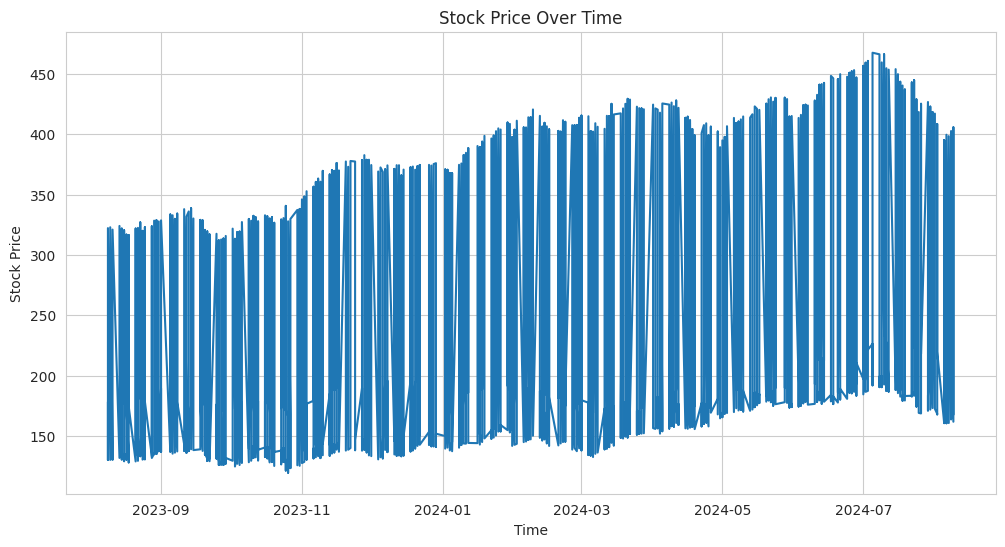

In [225]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()


3. **Scaling Data**: We use `MinMaxScaler` to scale the 'Close' prices to a range between -1 and 1. This step is crucial for training the LSTM model as it helps in faster convergence.


In [226]:
# Scaling both features and target
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))


4. **Preparing Data for LSTM**:

We will now define the sequence length and create sequences of the scaled 'Close' prices. We need to prepare the data in a way that is suitable for the LSTM model to process. This involves creating sequences of data that the LSTM can learn from. Here's how we do it: The `create_sequences` function generates input-output pairs where each input sequence of length `seq_length` corresponds to a single output value (the next value in the sequence). This preparation ensures that the LSTM model has the necessary historical data to learn from and predict future stock prices.

We chose a sequence length of **50** so that the model has enough historical context to read patterns and the sequence length is neither too long or too short. Play around with this hyperparameter and compare the results!

In [227]:
# Prepare data for LSTM
sequence_length = 50  # Length of the sequence for LSTM
data = df['Close'].values

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x_data, y_data = create_sequences(data, sequence_length)

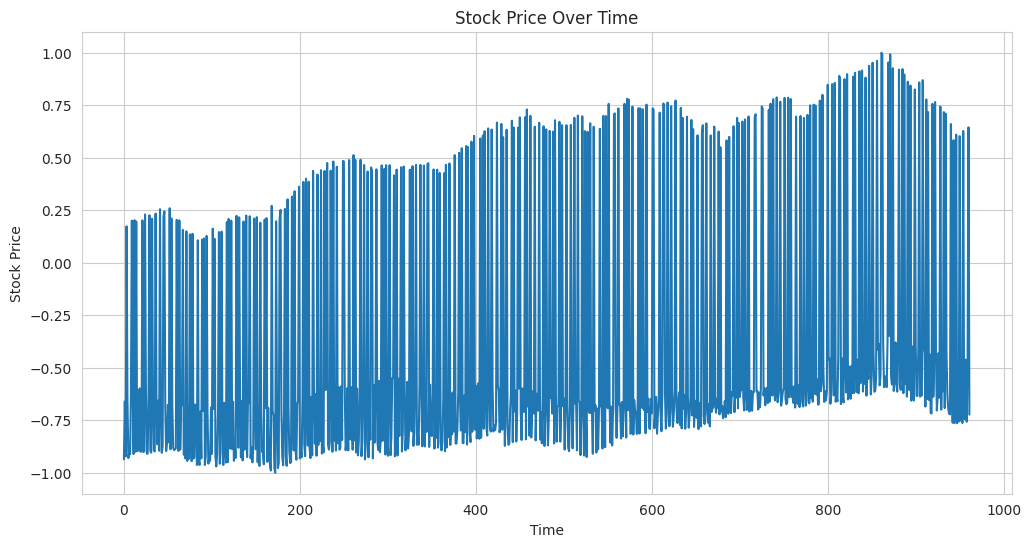

In [228]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(y_data)
plt.title('Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()


# Data Preprocessing
In this step, you need to split the data into training and test sets and convert them to PyTorch tensors. Follow these steps:
1. **Split the data into training and test sets.** Use a 70-30 split for training and test data (since x_data and y_data are NumPy arrays, you can do this manually through array slicing).
2. **Expand the dimensions of the data.** This step ensures that the data has the right shape for the LSTM model. For example, you can do this for your x_train set by doing: x_train = np.expand_dims(x_train, axis=-1).
3. **Convert the data to PyTorch tensors.** Use `torch.from_numpy` to convert the NumPy arrays to PyTorch tensors (also be sure to call the `float()` function on the tensors). Hint: if needed, for the y_train and y_test, call `view(-1,1)` on the tensors to properly reshape them.
    

In [229]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=25)

In [230]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [231]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).view(-1,1).float()
y_test = torch.from_numpy(y_test).view(-1,1).float()

In [232]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([673, 50, 1]),
 torch.Size([289, 50, 1]),
 torch.Size([673, 1]),
 torch.Size([289, 1]))


# Model Building
Define the LSTM model architecture using PyTorch:
1. **Import the necessary PyTorch libraries.** Import `torch`, `torch.nn`, and other relevant modules.
2. **Define the LSTM model class.** Create a class that inherits from `nn.Module` and define the LSTM layers and the forward pass.
3. **Initialize your hyperparameters (ex. input_dim, hidden_dim, num_layers, output_dim, num_epochs, learning rate, etc.), initialize the model, and define the loss function and the optimizer.** Use `nn.MSELoss` for the loss function and `torch.optim.Adam` or any other optimizer of your choice.
    

In [233]:
hidden_dim = 64
num_layers = 1
learning_rate = 0.001
dropout = 0
# batch_size = 16

In [234]:
class LSTMModel(nn.Module):
  def __init__(self):
    super(LSTMModel, self).__init__()
    self.lstm1 = nn.LSTM(input_size=1, hidden_size=hidden_dim*2, num_layers=num_layers, batch_first=True, dropout=dropout)
    self.lstm2 = nn.LSTM(input_size=hidden_dim*2, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
    self.fc1 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    out, _ = self.lstm1(x)
    out, _ = self.lstm2(out)
    out = out[:, -1, :]
    out = self.fc1(out)
    return out

In [235]:
import torch.utils.data as data
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)


# Model Training
Train the LSTM model with the prepared data:
1. **Implement the training loop.** Iterate over the training data, perform forward and backward passes, and update the model weights.
2. **Use a loss function to track training performance.**
    

In [236]:
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    # for X_train, y_train in loader:
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(criterion(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(criterion(y_pred, y_test))

    if (epoch+1) % 50 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}')

Epoch [50/500], Train RMSE: 0.5801, Test RMSE: 0.5714
Epoch [100/500], Train RMSE: 0.5215, Test RMSE: 0.5409
Epoch [150/500], Train RMSE: 0.5126, Test RMSE: 0.5274
Epoch [200/500], Train RMSE: 0.5048, Test RMSE: 0.5225
Epoch [250/500], Train RMSE: 0.4985, Test RMSE: 0.5176
Epoch [300/500], Train RMSE: 0.4997, Test RMSE: 0.5342
Epoch [350/500], Train RMSE: 0.4767, Test RMSE: 0.5345
Epoch [400/500], Train RMSE: 0.4981, Test RMSE: 0.5662
Epoch [450/500], Train RMSE: 0.4500, Test RMSE: 0.5629
Epoch [500/500], Train RMSE: 0.4322, Test RMSE: 0.5739



# Prediction
Use the trained model to make stock price predictions:
1. **Implement the prediction function.** Use the trained model to generate predictions on the test data.
2. **Evaluate the model's performance on the test data.** Calculate metrics like MSE or MAE to assess the model's performance (if you're using PyTorch's `nn.MSELoss` function, you can use the `item()` function to get the MSE).
3. **Visualize the predicted vs actual stock prices.** Plot the predicted and actual prices to visually inspect the model's performance.
    

In [237]:
predictions = model(X_test)
predictions = scaler.inverse_transform(predictions.detach().numpy())
y_test_actual = scaler.inverse_transform(y_test.detach().numpy())

In [238]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
print(f"# Mean Squared Error (MSE): {mse}")
print(f"# Mean Absolute Error (MAE): {mae}")

# Mean Squared Error (MSE): 9972.0791015625
# Mean Absolute Error (MAE): 73.47621154785156


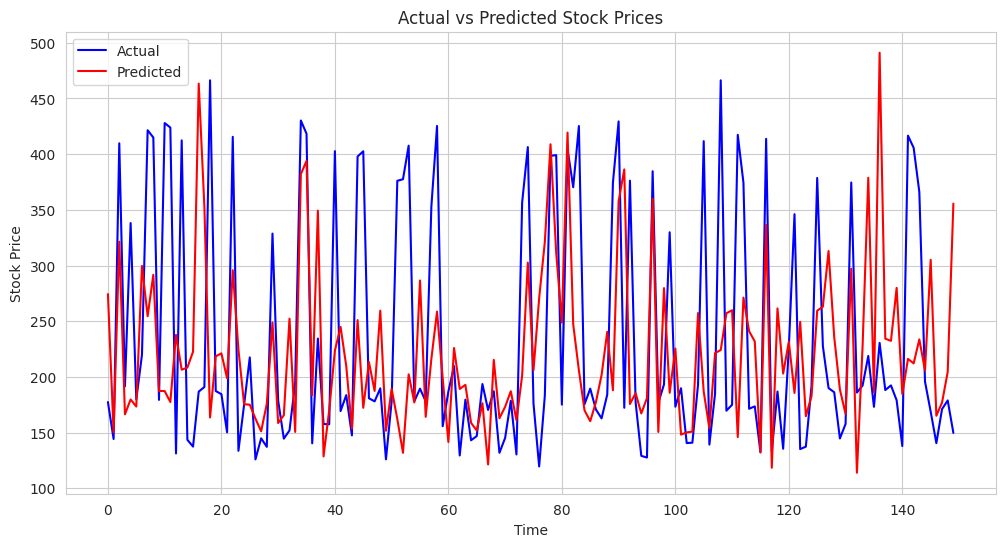

In [239]:
# pred vs actual plot
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:150], label='Actual', color='blue')
plt.plot(predictions[:150], label='Predicted', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Results

## Results of different trials by changing batch size, epochs, dropout, and number of layers.

| Batch Size | Epochs | Num Layers | Dropout | MSE       | MAE    | Notes                                    |
|------------|--------|------------|---------|-----------|--------|------------------------------------------|
| 16         | 300    | 2          | 0       | 9547.61   | 64.56  | No large spikes                          |
| 16         | 300    | 2          | 0.2     | 9898.52   | 63.08  | Predicts a nearly straight line          |
| 16         | 300    | 1          | 0       | 15891.47  | 99.73  | Random spikes mostly larger than actual  |
| 16         | 300    | 1          | 0.2     | 18938.28  | 97.61  | Wrong spikes predicted                   |
| 8          | 300    | 2          | 0       | 9968.46   | 60.36  | Few correct high spikes in a nearly straight line |
| 8          | 300    | 2          | 0.2     | 11423.21  | 60.61  | Short spikes                             |
| 8          | 300    | 1          | 0       | 14486.99  | 94.72  | Large spikes somewhat random             |
| 8          | 300    | 1          | 0.2     | 14808.35  | 98.26  | Random large spikes                      |
| 8          | 300    | 2          | 0.25    | 11996.76  | 64.05  |                                          |
| 8          | 300    | 2          | 0.5     | 11433.28  | 69.67  | Medium spikes                            |
| 8          | 300    | 1          | 0.25    | 13173.20  | 65.85  | Short spikes                             |
| 8          | 300    | 1          | 0.5     | 11482.81  | 62.96  | Short spikes                             |


## Performance Comparison of LSTM model by changing number of LSTM and Linear layers

| Model Architecture         | Batch Size | Num Layers | Learning Rate | Epochs | MSE       | MAE    | Notes           |
|----------------------------|------------|------------|---------------|--------|-----------|--------|-----------------|
| 2 LSTM, 1 Linear            | 1          | 1          | 0.001         | 500    | 8019.90   | 67.35  | Best Model      |
| 2 LSTM, 2 Linear            | 1          | 1          | 0.001         | 500    | 16688.56  | 96.70  | Random spikes   |